In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import rescomp

import matplotlib.pyplot as plt

In [2]:
import sys
sys.executable

'C:\\Users\\Dennis\\anaconda3\\envs\\rc_env_np16p6\\python.exe'

## Lorenz System:


In [21]:
# data creation function: LORENZ (sigma=10, rho=28, beta=8/3) using runge_kutta:

def data_creation_function(dt, time_steps, starting_point):
    return rescomp.simulate_trajectory(
            sys_flag='lorenz', dt=dt, time_steps=time_steps,
            starting_point=starting_point)

def jacobian_lorenz(x):
    sigma=10# 10
    rho=28
    beta=8/3
    return np.array([[-sigma, sigma, 0],
                                    [-x[2] + rho, -1, -x[0]],
                                    [x[1], x[0], -beta]])

In [18]:
# PARAMETERS:

# starting_point = np.array([3, 2, 3])
np.random.seed(1)
starting_point = np.random.randn(3)

dt = 0.02 # simulation time step
N = 100
tau = 100
eps = 1e-10
T = 0.5
m = 3
jacobian = jacobian

# LITERATURE VALUES:
lyapunov_exp_literature = [0.9038, 0.0001, -14.5705]

In [19]:
def f(x):
    return data_creation_function(dt, time_steps=2, starting_point=x)[-1]



out = rescomp.measures.iterator_based_lyapunov_spectrum(f, 
                                                         starting_point, 
                                                         T=T, 
                                                         tau=tau,
                                                         eps=eps, 
                                                         nr_steps=N, 
                                                         dt=dt, 
                                                         return_convergence=True,
                                                         nr_of_lyapunovs=m,
                                                         jacobian=None)

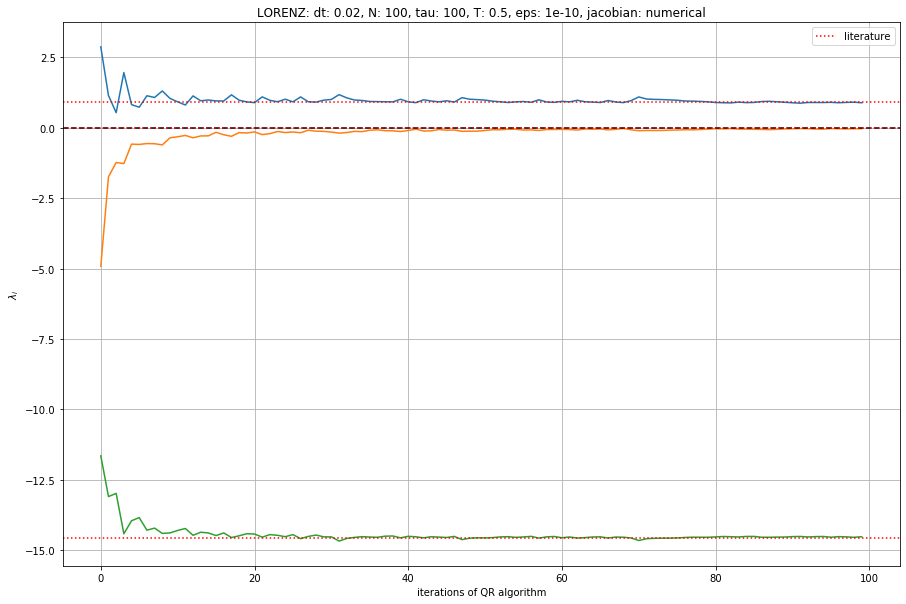

In [20]:
lyaps, lyaps_development = out

title = f"LORENZ: dt: {dt}, N: {N}, tau: {tau}, T: {T}, eps: {eps}, jacobian: numerical"
plt.figure(figsize=(15, 10))

plt.title(title)
plt.xlabel("iterations of QR algorithm")
plt.ylabel(r"$\lambda_i$")
plt.plot(lyaps_development[:, :])
plt.grid()
plt.axhline(0, c="k", linestyle ="--")
for i, y in enumerate(lyapunov_exp_literature):
    if i == 0:
        plt.axhline(y, c="r", linestyle=":", label="literature")
    else:
        plt.axhline(y, c="r", linestyle=":")
# plt.ylim(-15, 4)
plt.legend()

## Parameters Sweep: 

Sweep T and dt for "numerical" and "analytical" jacobian 

In [88]:
np.random.seed(1)
# PARAMETERS:

# fixed params:

# dt = 0.005 # simulation time step
N = 50# 100
tau = 100
eps = 1e-4
m = 3
N_ens = 5
# jacobian_str = "analytical" # "numerical"

starting_points = np.random.randn(N_ens, 3)

# sweep params:
Ts = [0.1, 0.3, 0.5, 1, 2, 3, 4]
dts = [0.005, 0.01, 0.05, 0.1]
jacobian_strs = ["numerical", "analytical"]

# LITERATURE VALUES:
lyapunov_exp_literature = [0.9038, 0.0001, -14.5705]

In [89]:
results = np.zeros((N_ens, len(jacobian_strs), len(dts), len(Ts), m))

for i_j, jacobian_str in enumerate(jacobian_strs):
    print(f"jacobian_str: {jacobian_str}")
    for i_dt, dt in enumerate(dts):
        print(f"dt: {dt}")
        for i_T, T in enumerate(Ts):
            print(f"T: {T}")
            if jacobian_str == "analytical":
                jacobian = jacobian_lorenz
            elif jacobian_str == "numerical":
                jacobian = None

            def f(x):
                return data_creation_function(dt, time_steps=2, starting_point=x)[-1]
            
            for i_st, starting_point in enumerate(starting_points):
                lyaps = rescomp.measures.iterator_based_lyapunov_spectrum(f, 
                                                             starting_point, 
                                                             T=T, 
                                                             tau=tau,
                                                             eps=eps, 
                                                             nr_steps=N, 
                                                             dt=dt, 
                                                             return_convergence=False,
                                                             nr_of_lyapunovs=m,
                                                             jacobian=jacobian)
                results[i_st, i_j, i_dt, i_T, :] = lyaps

jacobian_str: numerical
dt: 0.005
T: 0.1
T: 0.3
T: 0.5
T: 1
T: 2
T: 3
T: 4
dt: 0.01
T: 0.1
T: 0.3
T: 0.5
T: 1
T: 2
T: 3
T: 4
dt: 0.05
T: 0.1
T: 0.3
T: 0.5
T: 1
T: 2
T: 3
T: 4
dt: 0.1
T: 0.1
T: 0.3
T: 0.5
T: 1
T: 2
T: 3
T: 4
jacobian_str: analytical
dt: 0.005
T: 0.1
T: 0.3
T: 0.5
T: 1
T: 2
T: 3
T: 4
dt: 0.01
T: 0.1
T: 0.3
T: 0.5
T: 1
T: 2
T: 3
T: 4
dt: 0.05
T: 0.1
T: 0.3
T: 0.5
T: 1
T: 2
T: 3
T: 4
dt: 0.1
T: 0.1
T: 0.3
T: 0.5
T: 1
T: 2
T: 3
T: 4


(7, 3)
(7, 3)
(7, 3)
(7, 3)
(7, 3)
(7, 3)
(7, 3)
(7, 3)


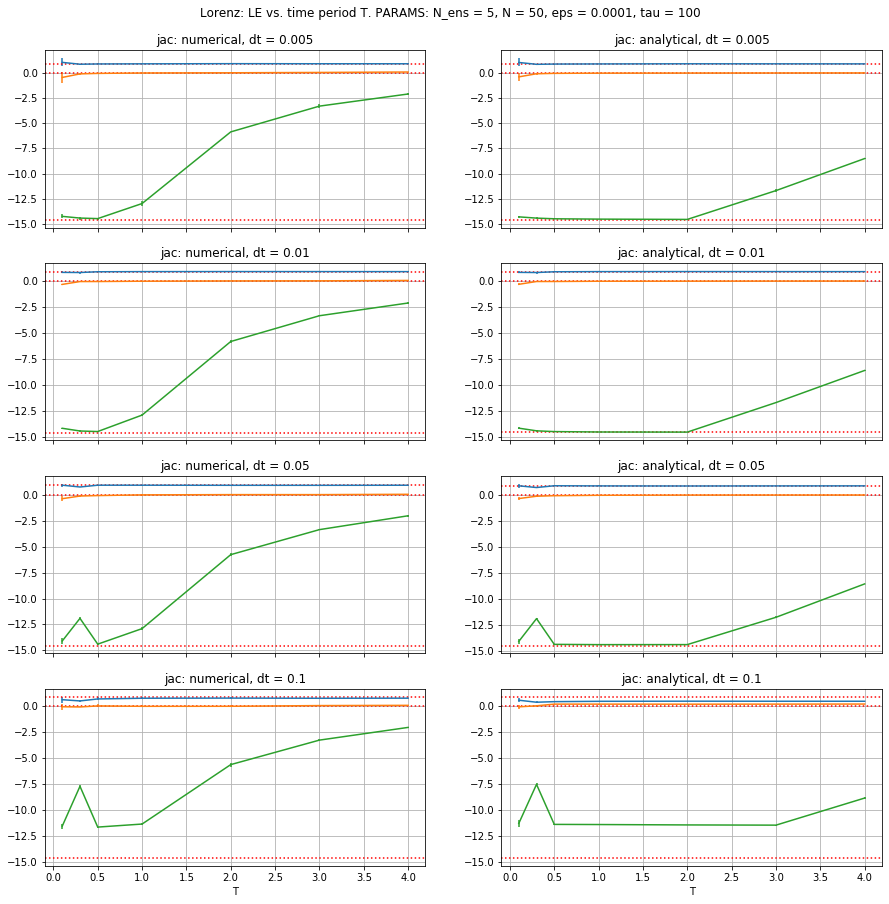

In [90]:
# PLOTTING
fig, axs = plt.subplots(len(dts), len(jacobian_strs), figsize=(15,15), sharex=True)
plt.suptitle(f"Lorenz: LE vs. time period T. PARAMS: N_ens = {N_ens}, N = {N}, eps = {eps}, tau = {tau}", y = 0.92)

for i_j, jacobian_str in enumerate(jacobian_strs):
    for i_dt, dt in enumerate(dts):
        ax = axs[i_dt, i_j]
        
        if results.shape[0] == 1: # ensemble size = 1
            to_plot = results[0, i_j, i_dt, :, :]
            ax.plot(Ts, to_plot)
        else:
            mean = results[:, i_j, i_dt, :, :].mean(axis=0)
            std = results[:, i_j, i_dt, :, :].std(axis=0)
            print(mean.shape)
            for i in range(m):
                ax.errorbar(x=Ts, y=mean[:, i], yerr=std[:, i])
        ax.set_title(f"jac: {jacobian_str}, dt = {dt}")
        ax.grid()
        for i, y in enumerate(lyapunov_exp_literature):
            if i == 0:
                ax.axhline(y, c="r", linestyle=":", label="literature")
            else:
                ax.axhline(y, c="r", linestyle=":")
    ax.set_xlabel("T")

## older:

In [ ]:
if jacobian_str == "analytical":
    jacobian = jacobian_lorenz
elif jacobian_str == "numerical":
    jacobian = None

def f(x):
    return data_creation_function(dt, time_steps=2, starting_point=x)[-1]

results = np.zeros((len(Ts), m))

for i, T in enumerate(Ts):
    print(f"T: {T}")
    lyaps = rescomp.measures.iterator_based_lyapunov_spectrum(f, 
                                                             starting_point, 
                                                             T=T, 
                                                             tau=tau,
                                                             eps=eps, 
                                                             nr_steps=N, 
                                                             dt=dt, 
                                                             return_convergence=False,
                                                             nr_of_lyapunovs=m,
                                                             jacobian=None)
    results[i, :] = lyaps

In [ ]:
plt.figure(figsize=(15,10))
plt.xlabel("T")
for i in range(m):
    plt.plot(Ts, results[:, i])
plt.grid()
for i, y in enumerate(lyapunov_exp_literature):
    if i == 0:
        plt.axhline(y, c="r", linestyle=":", label="literature")
    else:
        plt.axhline(y, c="r", linestyle=":")
plt.xscale("linear")
plt.legend()

#### Sweep dt: